# From Data to Intelligence — Workshop Notebook (Post-run) — High-Confidence Demo
**Theme:** Predicting Your Launchpad (Career Trajectories)  
**Flow:** Classical ML (multiclass classification) → GenAI (explain + uplift plan)  

> Note: The dataset is synthetic and intentionally **more separable** (less noise), so students can see ML “work” clearly.


## 0) Setup: 3 career trajectory tiers (multiclass)
- **Tier 1 — Product/Core**
- **Tier 2 — Specialized/Niche**
- **Tier 3 — Core Foundations**

We compare:
1) Multinomial Logistic Regression (baseline)  
2) Random Forest (non-linear, typically higher accuracy on this toy data)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## 1) Generate a more separable dataset (toy)
Inputs:
- attendance_%
- academic_score
- project_strength


In [2]:
rng = np.random.default_rng(42)
n = 1500

attendance = rng.normal(78, 10, n).clip(40, 100)
academic = rng.normal(70, 12, n).clip(20, 100)

# Projects are strongly informative + slightly tied to academics
project = (0.55*academic + rng.normal(0, 10, n)).clip(0, 100)

# Lower noise for clearer separability (main change vs earlier notebook)
noise = rng.normal(0, 0.45, n)

launchpad_score = (
    0.03*(attendance - 70) +
    0.06*(academic - 60) +
    0.10*(project - 50) +
    noise
)

tier = np.where(launchpad_score > 2.0, "Tier 1",
        np.where(launchpad_score > 0.8, "Tier 2", "Tier 3"))

df = pd.DataFrame({
    "attendance_%": attendance.round(1),
    "academic_score": academic.round(1),
    "project_strength": project.round(1),
    "trajectory_tier": tier
})

df.head()


,attendance_%,academic_score,project_strength,trajectory_tier
0,81.0,63.2,47.3,Tier 3
1,67.6,62.5,41.3,Tier 3
2,85.5,85.9,66.9,Tier 1
3,87.4,74.0,25.2,Tier 3
4,58.5,67.5,34.4,Tier 3


In [3]:
df["trajectory_tier"].value_counts()


trajectory_tier
Tier 3    1104
Tier 2     248
Tier 1     148
Name: count, dtype: int64

### Visual intuition


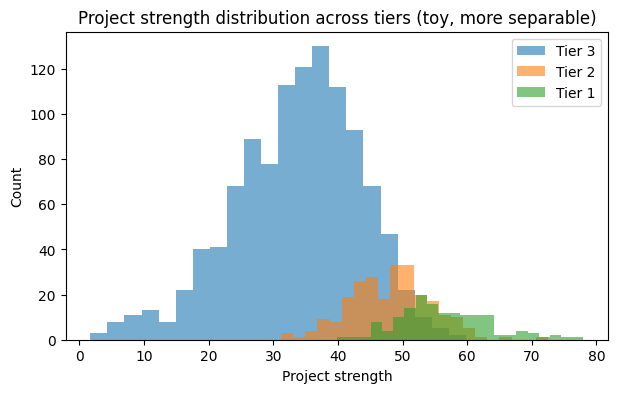

In [4]:
fig = plt.figure(figsize=(7,4))
for t in ["Tier 3","Tier 2","Tier 1"]:
    plt.hist(df.loc[df.trajectory_tier==t, "project_strength"], bins=22, alpha=0.6, label=t)
plt.title("Project strength distribution across tiers (toy, more separable)")
plt.xlabel("Project strength")
plt.ylabel("Count")
plt.legend()
plt.show()


## 2) Train / test split (honest evaluation)


In [5]:
X = df[["attendance_%","academic_score","project_strength"]]
y = df["trajectory_tier"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))


Train size: 1125 Test size: 375


## 3) Model A — Multinomial Logistic Regression (baseline)


In [6]:
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=600, multi_class="multinomial"))
])

logreg.fit(X_train, y_train)
pred_lr = logreg.predict(X_test)

acc_lr = accuracy_score(y_test, pred_lr)
print("LogReg accuracy:", round(acc_lr, 4))


LogReg accuracy: 0.896


## 4) Model B — Random Forest (higher accuracy on this toy data)


In [7]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, pred_rf)
print("Random Forest accuracy:", round(acc_rf, 4))


Random Forest accuracy: 0.8667


## 5) Confusion matrix (Random Forest)


In [8]:
labels = ["Tier 1","Tier 2","Tier 3"]
cm = confusion_matrix(y_test, pred_rf, labels=labels)
print(pd.DataFrame(cm, index=labels, columns=labels))


        Tier 1  Tier 2  Tier 3
Tier 1      26      10       1
Tier 2       8      37      17
Tier 3       0      14     262


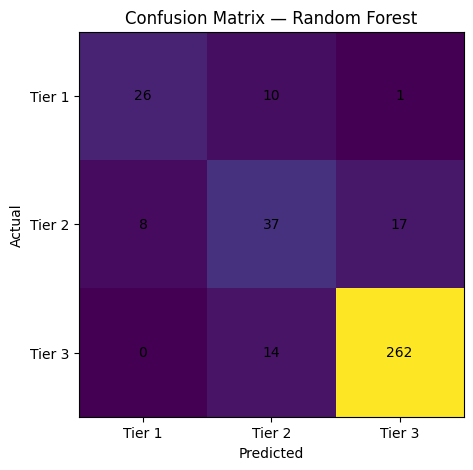

In [9]:
fig = plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix — Random Forest")
plt.xticks([0,1,2], labels)
plt.yticks([0,1,2], labels)
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 6) “What-if” demo: probabilities shifting across trajectories


In [10]:
def predict_with_probs(model, attendance_pct, academic_score, project_strength):
    row = pd.DataFrame([{
        "attendance_%": attendance_pct,
        "academic_score": academic_score,
        "project_strength": project_strength
    }])
    probs = model.predict_proba(row)[0]
    out = pd.DataFrame({"tier": model.classes_, "prob": probs}).sort_values("prob", ascending=False)
    return out, row

profiles = [
    ("Profile A (strong projects)", 82, 72, 88),
    ("Profile B (average)",        75, 66, 55),
    ("Profile C (low projects)",   80, 70, 30),
]

for name, a, ac, p in profiles:
    out, _ = predict_with_probs(rf, a, ac, p)
    print("\n" + name)
    print(out.to_string(index=False))



Profile A (strong projects)
  tier   prob
Tier 1 0.5725
Tier 2 0.3875
Tier 3 0.0400

Profile B (average)
  tier   prob
Tier 2 0.5900
Tier 3 0.3925
Tier 1 0.0175

Profile C (low projects)
  tier  prob
Tier 3  0.98
Tier 2  0.02
Tier 1  0.00


## 7) GenAI extension (offline-safe)
We build a prompt (what you'd send to an LLM) and show a simulated response so the demo works without internet.


In [11]:
def build_genai_prompt(student_row: pd.DataFrame, prob_table: pd.DataFrame) -> str:
    s = student_row.iloc[0].to_dict()
    top_tier = prob_table.iloc[0]["tier"]
    return f"""You are an AI mentor for engineering students.

Student signals:
- Attendance (%): {s['attendance_%']}
- Academic score (/100): {s['academic_score']}
- Project strength (/100): {s['project_strength']}

Model prediction (multiclass):
- Predicted trajectory: {top_tier}
- Probabilities:
{prob_table.to_string(index=False)}

Task:
1) Explain the result in simple terms (max 5 bullets)
2) Give a 7-day uplift plan (max 6 bullets)
3) Suggest 2 realistic technical projects that can improve their trajectory
Return in clean bullets."""


def simulated_genai_response(predicted_tier: str, prob_table: pd.DataFrame) -> str:
    p_map = {r["tier"]: float(r["prob"]) for _, r in prob_table.iterrows()}
    return (
        "Explanation (simple):\n"
        f"- Your current best-aligned trajectory is **{predicted_tier}**.\n"
        f"- Probabilities: Tier 1={p_map.get('Tier 1',0):.2f}, Tier 2={p_map.get('Tier 2',0):.2f}, Tier 3={p_map.get('Tier 3',0):.2f}.\n"
        "- Biggest lever: stronger projects + consistent effort.\n"
        "\n"
        "7-day uplift plan:\n"
        "- Day 1: Pick one project theme + set a daily 60–90 min slot.\n"
        "- Day 2–3: Build a mini-project with README + demo output.\n"
        "- Day 4: Add one measurable improvement (metric/plot).\n"
        "- Day 5: Practice explaining your project in 2 minutes.\n"
        "- Day 6: Strengthen fundamentals with focused practice.\n"
        "- Day 7: Update GitHub + resume with proof (plots/metrics/demo).\n"
        "\n"
        "Two realistic project ideas:\n"
        "- Signal classification (FFT features → multiclass model → confusion matrix).\n"
        "- Sensor anomaly detection (features → classifier → plots).\n"
    )

prob_table, student_row = predict_with_probs(rf, 82, 72, 88)
predicted = prob_table.iloc[0]["tier"]
prompt = build_genai_prompt(student_row, prob_table)

print("PROMPT (GenAI):\n")
print(prompt[:900] + " ...\n")
print("SIMULATED GENAI RESPONSE (offline-safe):\n")
print(simulated_genai_response(predicted, prob_table))


PROMPT (GenAI):

You are an AI mentor for engineering students.

Student signals:
- Attendance (%): 82
- Academic score (/100): 72
- Project strength (/100): 88

Model prediction (multiclass):
- Predicted trajectory: Tier 1
- Probabilities:
  tier   prob
Tier 1 0.5725
Tier 2 0.3875
Tier 3 0.0400

Task:
1) Explain the result in simple terms (max 5 bullets)
2) Give a 7-day uplift plan (max 6 bullets)
3) Suggest 2 realistic technical projects that can improve their trajectory
Return in clean bullets. ...

SIMULATED GENAI RESPONSE (offline-safe):

Explanation (simple):
- Your current best-aligned trajectory is **Tier 1**.
- Probabilities: Tier 1=0.57, Tier 2=0.39, Tier 3=0.04.
- Biggest lever: stronger projects + consistent effort.

7-day uplift plan:
- Day 1: Pick one project theme + set a daily 60–90 min slot.
- Day 2–3: Build a mini-project with README + demo output.
- Day 4: Add one measurable improvement (metric/plot).
- Day 5: Practice explaining your project in 2 minutes.
- Day 6: S

## 8) Workshop honesty note
High accuracy here is because the dataset is synthetic and cleaner.  
In real life, accuracy depends on data quality, feature design, and real-world noise.
